# E-commerce A/B Test — Clean & Simple (Portfolio-Ready, EN)

**Goal.** Check whether the new landing page (`new_page`, *treatment*) improves conversion compared to the old page (`old_page`, *control*).  
**Primary metric.** Conversion Rate (CR).  
**Design.** 50/50 random split by user.

**Key results (from this run):**
- CR (control): **12.04%**
- CR (treatment): **11.88%**
- Relative uplift: **-1.31%**
- p-value: **0.1899**
- 95% CI (treatment − control): **[-0.39%, 0.08%]**

**Conclusion.** Treatment CR is slightly lower; the difference is **not statistically significant** (p ≥ 0.05).

## 1. Load & preview

In [ ]:
import pandas as pd
df = pd.read_csv('ab_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

 user_id                  timestamp     group landing_page  converted
  851104 2017-01-21 22:11:48.556739   control     old_page          0
  804228 2017-01-12 08:01:45.159739   control     old_page          0
  661590 2017-01-11 16:55:06.154213 treatment     new_page          0
  853541 2017-01-08 18:28:03.143765 treatment     new_page          0
  864975 2017-01-21 01:52:26.210827   control     old_page          1

## 2. Data cleaning

In [ ]:
# Keep valid pairs only: control→old_page, treatment→new_page
mask_ok = ((df['group']=='control') & (df['landing_page']=='old_page')) |           ((df['group']=='treatment') & (df['landing_page']=='new_page'))
bad_rows = (~mask_ok).sum()
print('Mismatched rows (removed):', bad_rows)

# Drop duplicate users (keep first occurrence by time)
dup_users = df['user_id'].duplicated().sum()
print('Duplicate user_id rows (removed):', dup_users)

df_clean = (df.loc[mask_ok]
              .sort_values('timestamp')
              .drop_duplicates(subset='user_id', keep='first')
              .copy())

print('Shape after cleaning:', df_clean.shape)
df_clean.to_csv('ab_data_clean.csv', index=False)

Mismatched rows (removed): 3893
Duplicate user_id rows (removed): 3894
Shape after cleaning: (290584, 5)


## 3. Group balance

In [ ]:
import pandas as pd
dfc = pd.read_csv('ab_data_clean.csv')
(dfc['group'].value_counts(normalize=True)*100).round(2)

treatment    50.01
control      49.99

## 4. Conversion by group

In [ ]:
import pandas as pd
dfc = pd.read_csv('ab_data_clean.csv')
agg = dfc.groupby('group')['converted'].agg(['sum','count'])
agg['cr'] = agg['sum']/agg['count']
agg

             sum   count        cr
group                             
control    17489  145274  0.120386
treatment  17264  145310  0.118808

## 5. Statistical test (two-proportion Z-test) + 95% CI

In [ ]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

dfc = pd.read_csv('ab_data_clean.csv')
agg = dfc.groupby('group')['converted'].agg(['sum','count'])
agg['cr'] = agg['sum']/agg['count']

x = agg.loc[['control','treatment'],'sum'].values
n = agg.loc[['control','treatment'],'count'].values
stat, pval = proportions_ztest(x, n)

pA = float(agg.loc['control','cr']); pB = float(agg.loc['treatment','cr'])
low, high = confint_proportions_2indep(count1=int(x[1]), nobs1=int(n[1]),
                                       count2=int(x[0]), nobs2=int(n[0]), method='wald')
uplift_rel = pB/pA - 1

print(f'Z-stat: {stat:.4f}, p-value: {pval:.6f}')
print(f'CR_control={pA:.4%}, CR_treatment={pB:.4%}, relative uplift={uplift_rel:.2%}')
print(f'95% CI (treatment - control): [{low:.4%}, {high:.4%}]')

Z-stat: 1.3109, p-value: 0.189883
CR_control=12.0386%, CR_treatment=11.8808%, relative uplift=-1.31%
95% CI (treatment - control): [-0.3938%, 0.0781%]


## 6. Visualization: CR by group

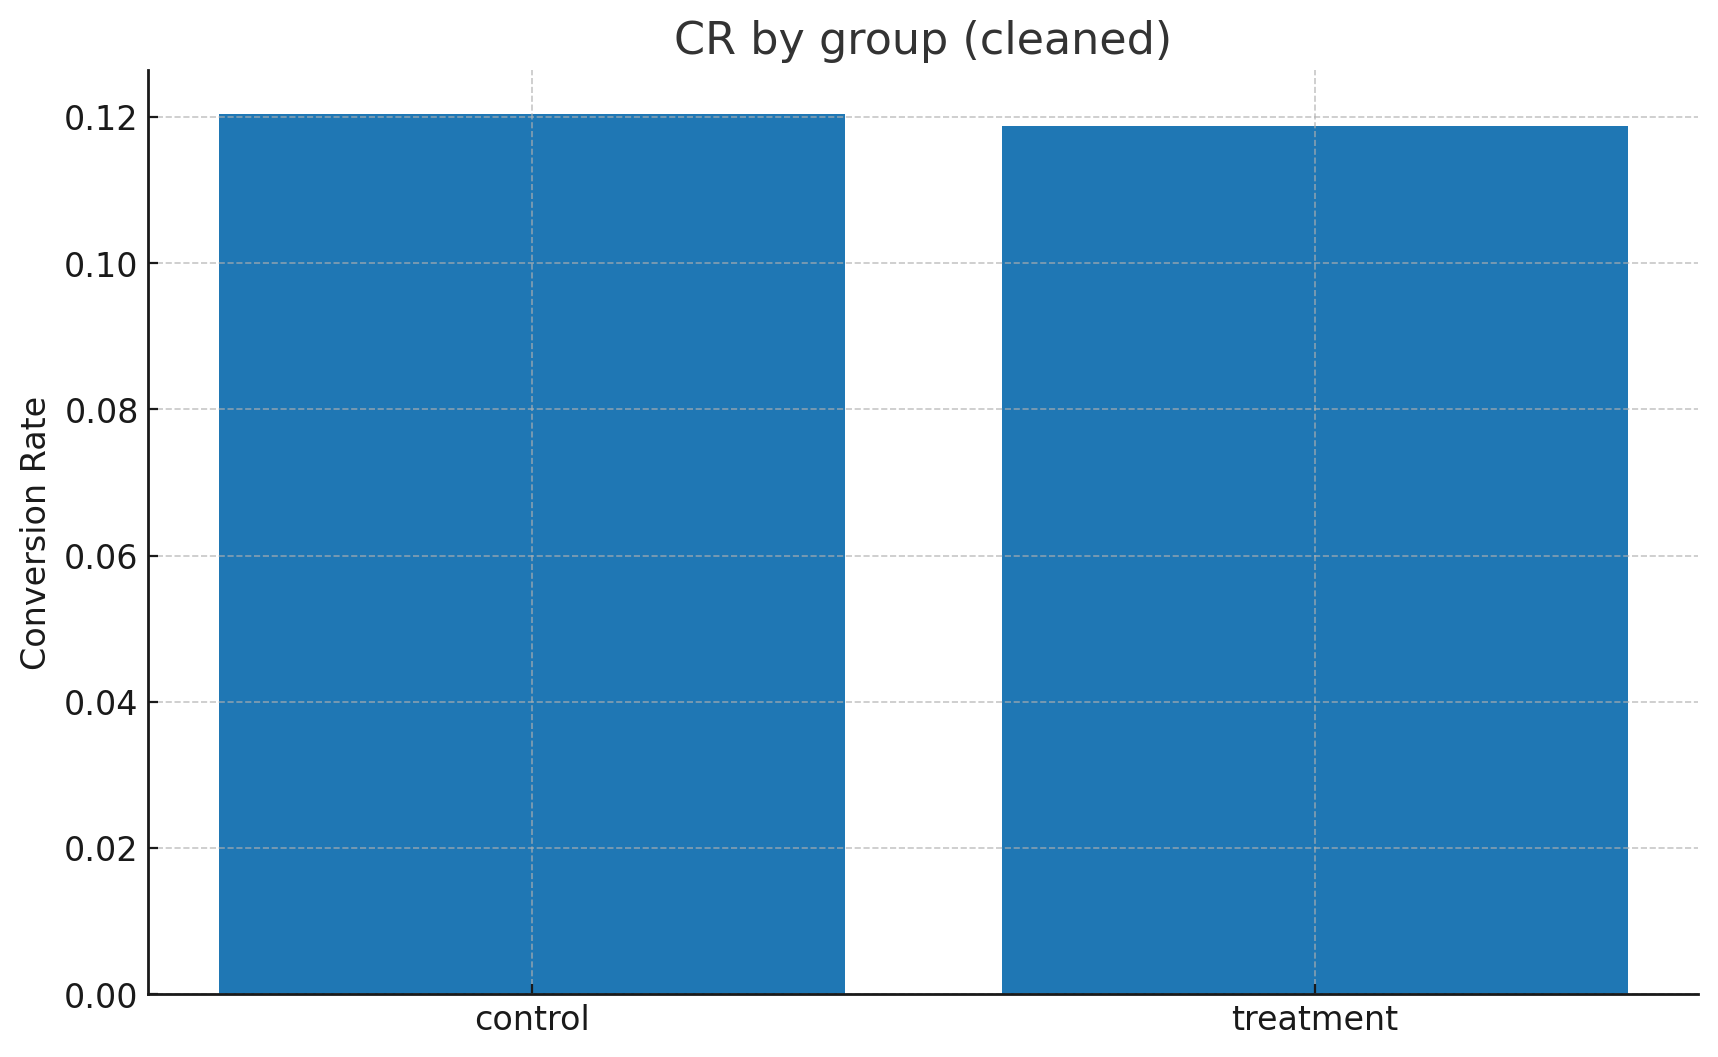

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
dfc = pd.read_csv('ab_data_clean.csv')
agg = dfc.groupby('group')['converted'].agg(['sum','count'])
agg['cr'] = agg['sum']/agg['count']

plt.figure()
plt.bar(agg.index, agg['cr'])
plt.ylabel('Conversion Rate')
plt.title('CR by group (cleaned)')
plt.show()

## 7. Bonus: Daily CR trend

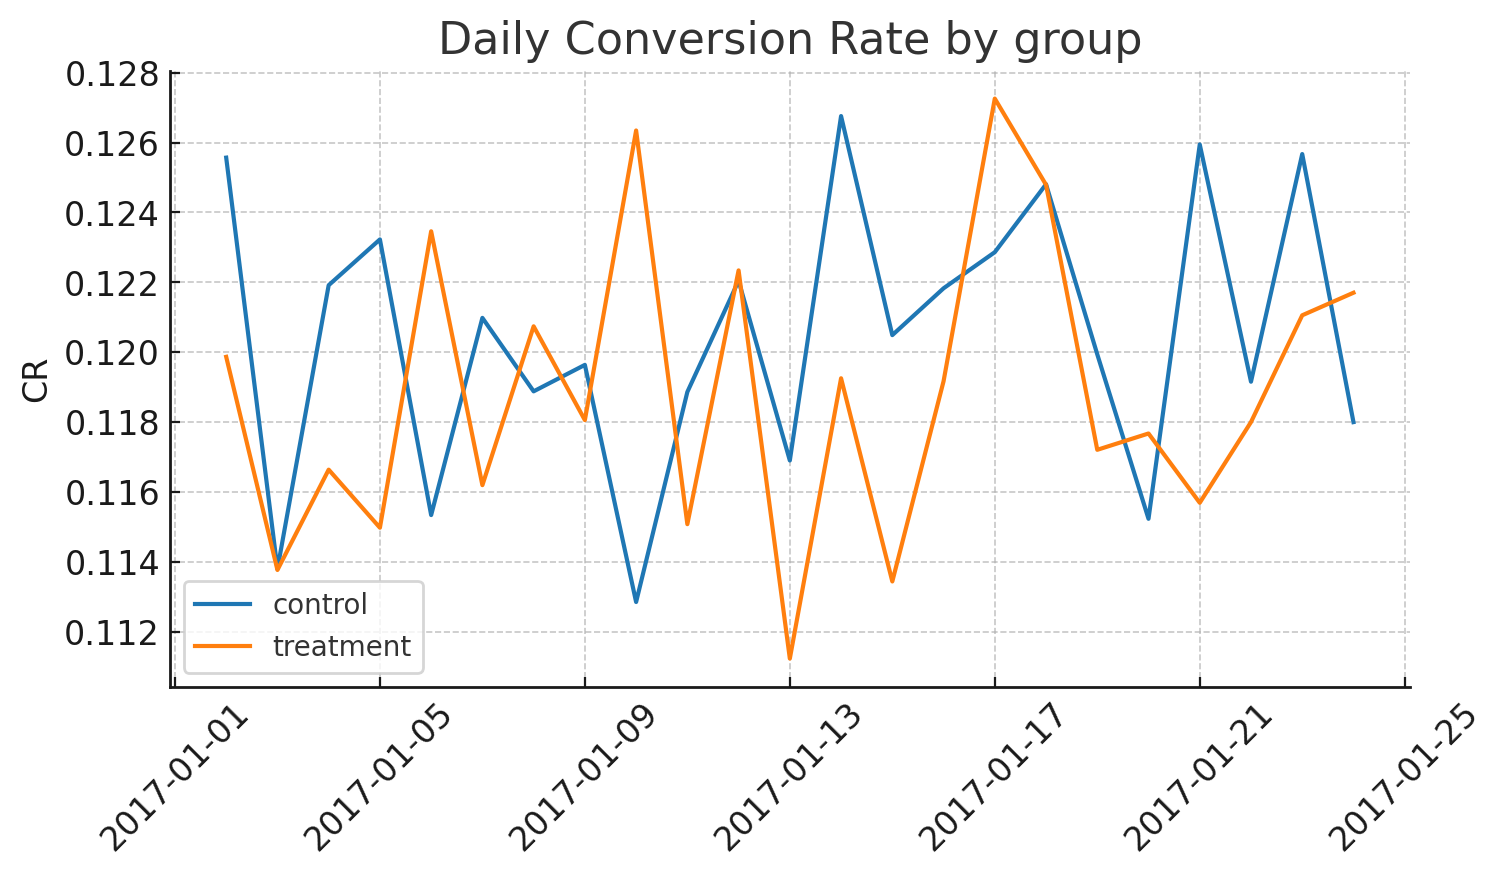

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

dfc = pd.read_csv('ab_data_clean.csv')
daily = (dfc.assign(date=pd.to_datetime(dfc['timestamp']).dt.date)
         .groupby(['date','group'])['converted']
         .mean()
         .unstack('group')
         .sort_index())

plt.figure(figsize=(8,4))
plt.plot(daily.index, daily['control'], label='control')
plt.plot(daily.index, daily['treatment'], label='treatment')
plt.title('Daily Conversion Rate by group')
plt.ylabel('CR')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## 8. Conclusion

**Summary.** On the cleaned dataset, treatment CR ≈ 11.88% vs control CR ≈ 12.04%.  
The difference is **not statistically significant** (p = 0.1899; 95% CI: [-0.39%, 0.08%]).  
Therefore, we **do not have evidence** that the new page performs better than the old page.